<h1>Content<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Preprocessing</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analysis</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#Machine-Learning" data-toc-modified-id="Machine-Learning-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Machine Learning</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#LightGBMRegressor" data-toc-modified-id="LightGBMRegressor-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>LightGBMRegressor</a></span></li><li><span><a href="#XGBRegressor" data-toc-modified-id="XGBRegressor-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>XGBRegressor</a></span></li><li><span><a href="#FBProphet" data-toc-modified-id="FBProphet-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>FBProphet</a></span></li></ul></li><li><span><a href="#Models-Analysis" data-toc-modified-id="Models-Analysis-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Models Analysis</a></span></li><li><span><a href="#General-Conclusion" data-toc-modified-id="General-Conclusion-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>General Conclusion</a></span></li></ul></div>

#  Taxi orders prediction

# We have a taxi orders data for few monthes of 2018. In porpouse to avoid drivers shortage we need to learn model to predict amount of orders in the next hour. Root mean squared error of prediction should be less then 48


## Data Preprocessing

In [ ]:
#import librarys
!pip install lightgbm

In [ ]:
!pip install pystan
!pip install prophet

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor



import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics


random_state = 12345



In [ ]:
#data import
data = pd.read_csv('/content/taxi.csv')
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [ ]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [ ]:
#convert to datetime
data['datetime'] = pd.to_datetime(data['datetime'])

In [ ]:
#set index
data = data.set_index('datetime')

In [ ]:
#check if index is monotonic
data.index.is_monotonic

True

In [ ]:
#resample to hourly
data = data.resample('1H').sum()

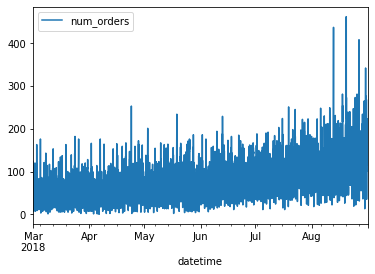

In [ ]:
#lets see what we have
data.plot()

In [ ]:
#function to create new features(year, month, day, dayofweek, moving_average, standard deviation of moving_average, seasonality and lags) 
def make_features(data, max_lag, moving_average_size):
    data_new = data.copy()
    data_new['year'] = data_new.index.year
    data_new['month'] = data_new.index.month
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek
    
    data_new['moving_average'] = data_new['num_orders'].shift().rolling(moving_average_size).mean()
    data_new['std'] = data_new['num_orders'].shift().rolling(moving_average_size).std()
    
    decomposed = seasonal_decompose(data_new['num_orders'])
    data_new['seasonality'] = decomposed.seasonal.shift()
  

    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

    
    return data_new

## Conclusion

- Data's on base
- Preprocessing has done
- Created function for adding new features


## Analysis

Lets see what seasonal, trend and residual components we have

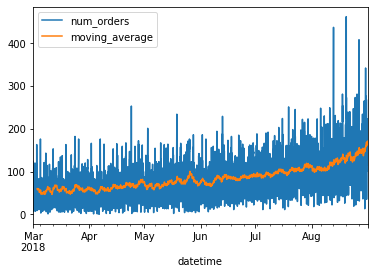

In [ ]:
make_features(data, 1, 55)[['num_orders', 'moving_average']].plot()

In [ ]:
decomposed = seasonal_decompose(data['num_orders'])

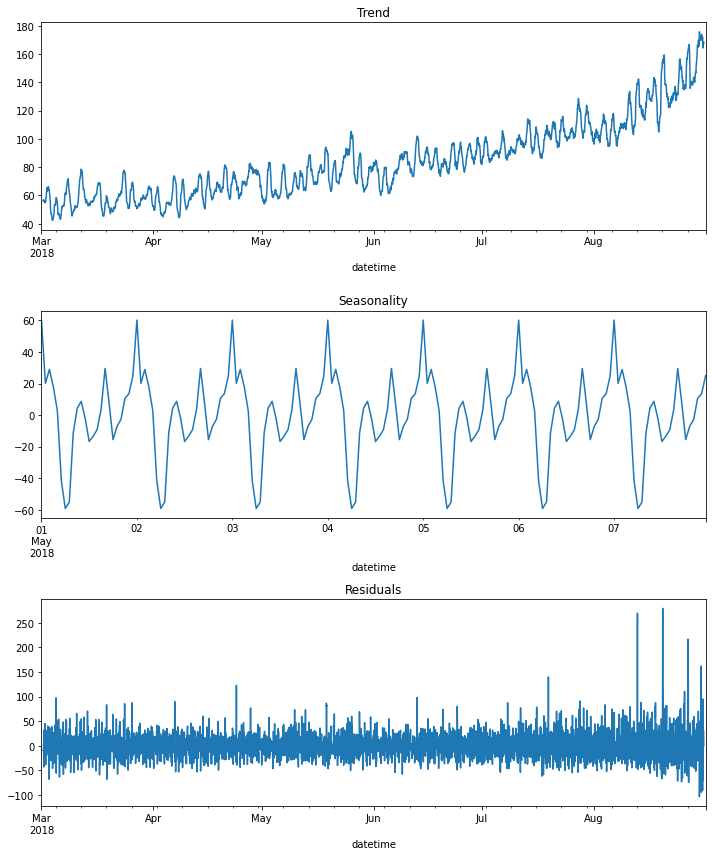

In [ ]:
plt.figure(figsize = (10, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-05-01':'2018-05-7'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

## Conclusion

After doing some preprocessing and analisys job we can say that:
 - time series has a trend - number of taxi ordes increases during all the time
 - time series has a seasonality - there are peaks in the morning (people get to work), afternoon (business meetings) and evening (get home, go out, etc.) 

## Machine Learning

In [ ]:
#create new features
data = make_features(data, 1, 55)

In [ ]:
data.head()

,num_orders,year,month,day,dayofweek,moving_average,std,seasonality,lag_1
datetime,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,NaN,NaN,60.248112,124.0
2018-03-01 02:00:00,71,2018,3,1,3,NaN,NaN,20.177074,85.0
2018-03-01 03:00:00,66,2018,3,1,3,NaN,NaN,28.982743,71.0
2018-03-01 04:00:00,43,2018,3,1,3,NaN,NaN,17.885407,66.0


In [ ]:
#split train and test sets
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

In [ ]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

### Linear Regression

In [ ]:
model = LinearRegression()

In [ ]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
lr_rmse = (mean_squared_error(y_test, model.predict(X_test))) ** 0.5
print('Linear Regression RMSE on test', lr_rmse)

Linear Regression RMSE on test 52.937925620834655


### LightGBMRegressor

In [ ]:
model= lgb.LGBMRegressor(random_state=random_state)
param_search = {'max_depth' : [-1, 5], 'learning_rate' : [0.1, 0.15]}

In [ ]:
#function for searching best parameters
def best_p(model, X, y, param_search=param_search):
    tscv = TimeSeriesSplit(n_splits=2)
    gsearch = GridSearchCV(estimator=model,
                           cv=tscv,param_grid=param_search,
                           scoring='neg_mean_squared_error')
    gsearch.fit(X_train, y_train)
    print(gsearch.best_params_)
    return gsearch.best_estimator_

best_p(model, X_train, y_train)

{'learning_rate': 0.1, 'max_depth': -1}


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
lgbm_model = best_p(model, X_train, y_train)

{'learning_rate': 0.1, 'max_depth': -1}


In [ ]:
#function to evaluate model on test data
def test_model(model, X_train, y_train, y_test):
    model.fit(X_train, y_train)
    return (mean_squared_error(y_test, model.predict(X_test))) ** 0.5
    
lgbmr_rmse = test_model(lgbm_model, X_train, y_train, y_test)
print('lightGBMRegressor RMSE on test', lgbmr_rmse)

lightGBMRegressor RMSE on test 42.13347386448493


### XGBRegressor

In [ ]:
model_2= XGBRegressor(random_state=random_state)
param_search = {'max_depth' : [3, 5], 'learning_rate' : [0.1, 0.15]}

In [ ]:
xgb_model = best_p(model_2, X_train, y_train, param_search=param_search)

[10:28:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:28:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:28:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:28:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:28:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:28:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:28:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:28:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
xgb_rmse = test_model(model=xgb_model, X_train=X_train, y_train=y_train, y_test=y_test)
print('XGBRegressor RMSE on test', xgb_rmse)

[10:28:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor RMSE on test 46.457466975909576


### FBProphet

In [ ]:
#reset index
data = data.reset_index().dropna()
data.head()

,datetime,num_orders,year,month,day,dayofweek,moving_average,std,seasonality,lag_1
55,2018-03-03 07:00:00,17,2018,3,3,5,59.963636,34.417891,-59.182671,9.0
56,2018-03-03 08:00:00,56,2018,3,3,5,58.018182,33.748795,-55.104461,17.0
57,2018-03-03 09:00:00,73,2018,3,3,5,57.490909,33.545366,-11.212840,56.0
58,2018-03-03 10:00:00,52,2018,3,3,5,57.527273,33.561361,4.443581,73.0
59,2018-03-03 11:00:00,57,2018,3,3,5,57.272727,33.548999,8.759269,52.0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Making 5 forecasts with cutoffs between 2018-04-03 23:00:00 and 2018-08-01 23:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


horizon     16 days 12:00:00
mse                  906.819
rmse                 29.8732
mae                  21.9205
mdape               0.210059
smape               0.265073
coverage            0.888833
dtype: object

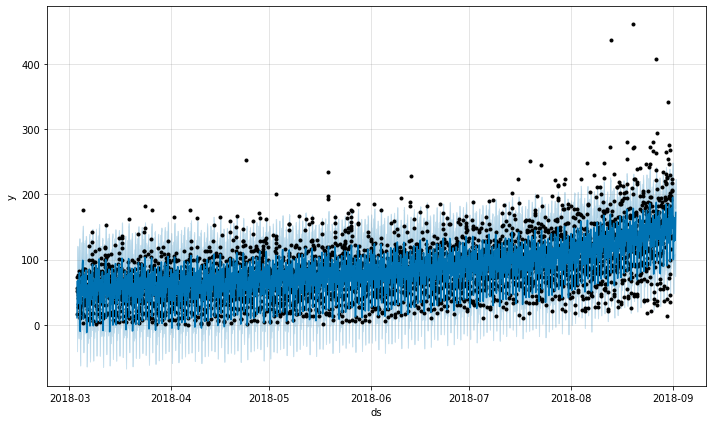

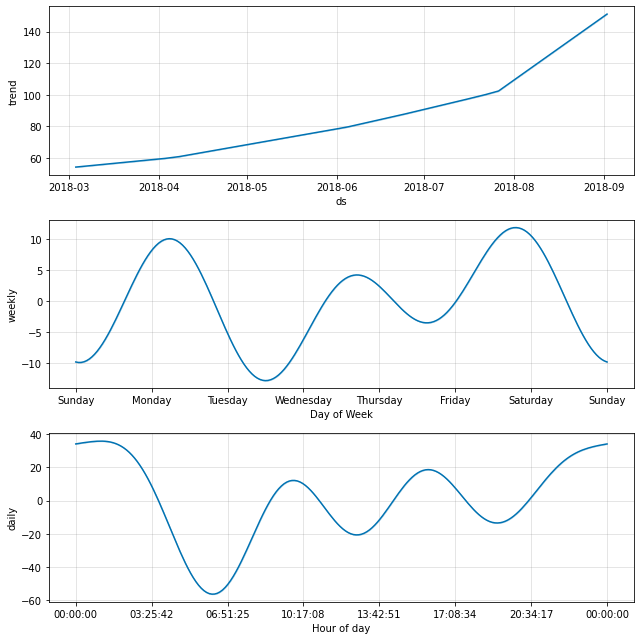

In [ ]:
#rename necessary columns and fit the model
data['y'] = data['num_orders']
data['ds'] = data['datetime']

 
m = Prophet(interval_width=0.95, daily_seasonality=True)
m.fit(data)

future = m.make_future_dataframe(periods=24, freq='H')
      
forecast = m.predict(future)
plot1 = m.plot(forecast)
plt2 = m.plot_components(forecast)
  
data_cv = cross_validation(m, initial='10 days', period='30 days', horizon = '30 days')
data_p = performance_metrics(data_cv)
data_p.mean()




In [ ]:
#metrics
data_p.mean()

horizon     16 days 12:00:00
mse                  906.819
rmse                 29.8732
mae                  21.9205
mdape               0.210059
smape               0.265073
coverage            0.888833
dtype: object

## Models Analysis

In [ ]:
#run the test by median constant model
print("Daily average number of orders:", test['num_orders'].mean())

pred_median = np.ones(test['num_orders'].shape) * np.median(train['num_orders'].values)

print("RMSE:", (mean_squared_error(test['num_orders'], pred_median)) ** 0.5)

Daily average number of orders: 139.55656108597285
RMSE: 87.15277582981295


In [ ]:
#put all metrics together and check out the results
metrics = [lr_rmse, lgbmr_rmse, xgb_rmse]

metrics = pd.DataFrame(metrics,
                        index = ['LinearRegression', 'LightGBMRegressor', 'XGBRegressor'], columns = ['RMSE'])
metrics

,RMSE
LinearRegression,52.937926
LightGBMRegressor,42.133474
XGBRegressor,46.457467


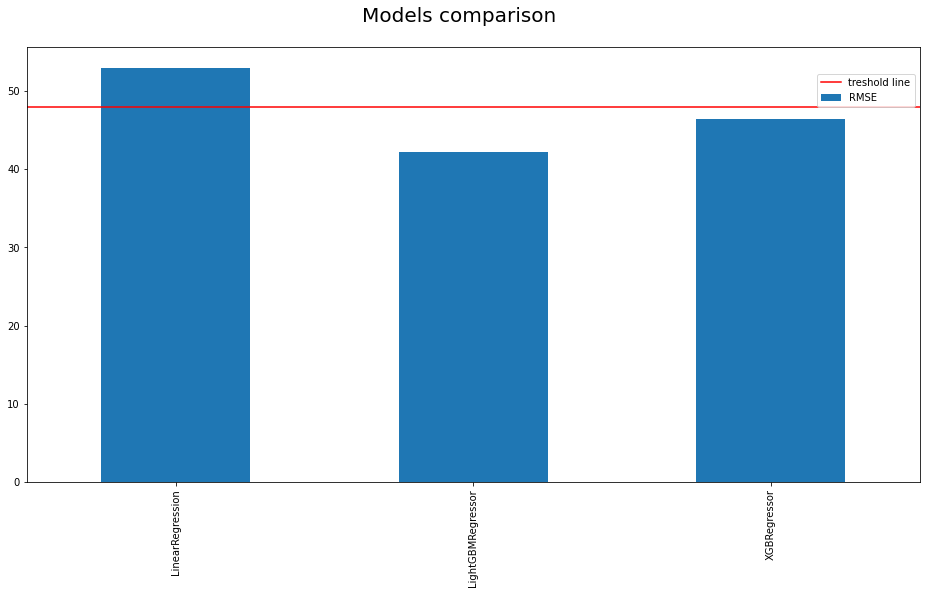

In [ ]:
metrics.plot(figsize=(16,8), kind='bar')
plt.suptitle('Models comparison', fontsize=20, y=.95)
plt.legend(loc=1, prop={'size': 20})
plt.axhline(48, color='red', label='treshold line')
plt.legend(loc="higher right", bbox_to_anchor=(0.5, 0.45, 0.5, 0.5))

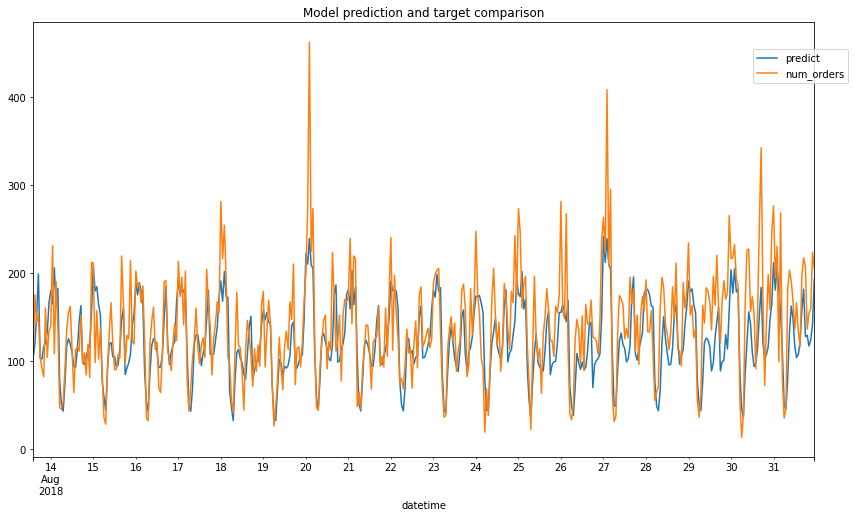

In [ ]:
#plot predictions and targets
pd.DataFrame(lgbm_model.predict(X_test), index=X_test.index, columns=['predict']).plot(figsize = (14, 8), 
                                                                                       title = 'Model prediction and target comparison')
y_test.plot()
plt.legend(loc="higher right", bbox_to_anchor=(0.55, 0.45, 0.5, 0.5))


## General Conclusion

In this project we built models to predict numbers of taxi orders, each of them passes a test by median constant model. Two of them match requirements (RMSE less then 48). The most accuracy results shows LightGBMRegressor - 48. FBProphet hits 29.9, but it evaluated by cross-validation on whole dataset (not just on test data like others). Which means we can compare them. Also I'm pretty sure we can get better results by tuning parametres of make_features function (max_lag and moving_average_size).   

